In [2]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/948.2 kB ? eta -:--:--
     -------------------------------------- 948.2/948.2 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.8-py3-none-any.whl size=139064 sha256=7dd331221a6b55a8119d4b2f9b6d77886fc6ed3a67cea65be7505d31db2d7ca2
  Stored in directory: c:\users\kiit\appdata\local\pip\cache\wheels\8f\65\34\456800445efeafb05164fe95285c70e81ba1d96bae30f43917
Successfully built peewee


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import yfinance as yf
import pandas as pd
import os

In [4]:
if os.path.exists("GSPC.csv"):
    sp500 = pd.read_csv("GSPC.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("GSPC.csv")

In [5]:
sp500.index = pd.to_datetime(sp500.index)

In [6]:
sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,16.660000,1260000
1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000
1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000
1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000
1950-01-09,17.080000,17.080000,17.080000,17.080000,17.080000,2520000
...,...,...,...,...,...,...
2018-05-31,2720.979980,2722.500000,2700.679932,2705.270020,2705.270020,4235370000
2018-06-01,2718.699951,2736.929932,2718.699951,2734.620117,2734.620117,3684130000
2018-06-04,2741.669922,2749.159912,2740.540039,2746.870117,2746.870117,3376510000


<Axes: xlabel='Date'>

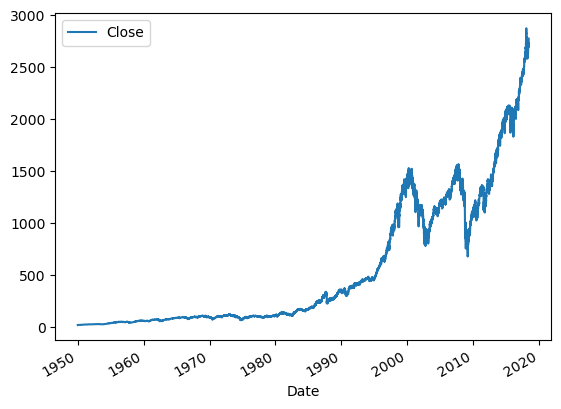

In [7]:
sp500.plot.line(y="Close", use_index=True)

In [10]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [11]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [12]:
sp500 = sp500.loc["1990-01-01":].copy()

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [14]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.54

<Axes: xlabel='Date'>

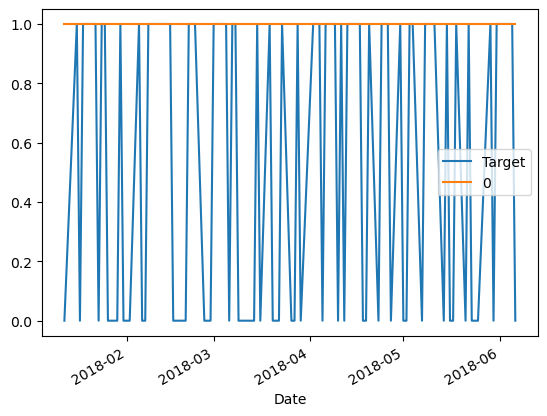

In [15]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [16]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [17]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [18]:
predictions = backtest(sp500, model, predictors)

In [19]:
predictions["Predictions"].value_counts()

Predictions
0    2692
1    1972
Name: count, dtype: int64

In [20]:
precision_score(predictions["Target"], predictions["Predictions"])

0.533975659229209

In [21]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.533662
0    0.466338
Name: count, dtype: float64

In [22]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [23]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [24]:
sp500

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31,2720.979980,2722.500000,2700.679932,2705.270020,2705.270020,4235370000,2734.620117,1,0.996548,1.0,0.996913,1.0,1.007554,30.0,1.040460,143.0,1.216238,531.0
2018-06-01,2718.699951,2736.929932,2718.699951,2734.620117,2734.620117,3684130000,2746.870117,1,1.005395,1.0,1.007220,2.0,1.018436,31.0,1.051265,144.0,1.228989,532.0
2018-06-04,2741.669922,2749.159912,2740.540039,2746.870117,2746.870117,3376510000,2748.800049,1,1.002235,2.0,1.009832,3.0,1.022948,31.0,1.055459,145.0,1.234045,532.0


In [25]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [26]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [27]:
predictions = backtest(sp500, model, new_predictors)

In [28]:
predictions["Predictions"].value_counts()

Predictions
0.0    2998
1.0     666
Name: count, dtype: int64

In [29]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5780780780780781

In [30]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.546943
0    0.453057
Name: count, dtype: float64

In [31]:
predictions

,Target,Predictions
Date,,
2003-11-14,0,0.0
2003-11-17,0,1.0
2003-11-18,1,1.0
2003-11-19,0,0.0
2003-11-20,1,1.0
...,...,...
2018-05-31,1,0.0
2018-06-01,1,0.0
2018-06-04,1,0.0
